In [ ]:
!pip install -q sklearn
!pip install torch torchvision
!pip3 install torchsummary
# !pip3 install torch==1.2.0+cu92 torchvision==0.4.0+cu92 -f https://download.pytorch.org/whl/torch_stable.html
!pip install tensorflow==2.7.0
!pip install patchify

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
# os.chdir('drive/Shareddrives/WIKM') run this line (and comment below) if drive in ur shared drives
os.chdir('/content/drive/MyDrive/WIKM')

Mounted at /content/drive


In [ ]:
print(len(os.listdir('/content/drive/MyDrive/WIKM/OsteosarcomaData/Non-Tumor')))
print(len(os.listdir('/content/drive/MyDrive/WIKM/OsteosarcomaData/Non-Viable-Tumor')))
print(len(os.listdir('/content/drive/MyDrive/WIKM/OsteosarcomaData/Viable')))

488
263
292


In [ ]:
!ls

 data				       patchedImagesPNG512x512
 lung_histopathology_bench_best.hdf5   Test_Images
 maskedImages			       vgg_bone_model_100epoch.h5
 normMaskedImages		      'WIKMM notes.gdoc'
'notes and articles'		      'WIKMM (update).gslides'
 OsteosarcomaData		      'WIKM new test.ipynb'
 output				       WIKMproject.ipynb
 patchedImagesPNG256x256	      'WIKM Test.ipynb'


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import argparse
import cv2
from google.colab.patches import cv2_imshow
import pathlib
import PIL
import os
import json

### Load tiff Images 

In [ ]:
pip install opencv-python

In [ ]:
# (I though there's some difference for loading tiff images but turns out it's as simple as loading jpg)
import cv2
img_arr = cv2.imread('data/LungCancer/FinalPublishedResults/LungFCP-01-0001/histology/imgs/LungFCP-01-0001_B1.tif')
print(img_arr.shape)
print(type(img_arr))

### Build structure

In [ ]:
'''
list of dict of dict of list
[
  {patient1:
    {slide1: 
      {path: imgPath},
      {airway: maskPath},
      {blood: maskPath},
      {invasive: [maskPath]},
      {in situ: [maskPath]},
      {both: [maskPath]}
    },
    {slide2:
      ...
    }
    ...
  },
  {patient2:
    ...
  },
  ...
]
'''

'\nlist of dict of dict of list\n[\n  {patient1:\n    {slide1: \n      {path: imgPath},\n      {airway: maskPath},\n      {blood: maskPath},\n      {invasive: [maskPath]},\n      {in situ: [maskPath]},\n      {both: [maskPath]}\n    },\n    {slide2:\n      ...\n    }\n    ...\n  },\n  {patient2:\n    ...\n  },\n  ...\n]\n'

In [ ]:
path = "data/LungCancer"
pathDataset = []
patients = os.listdir(path)
patients.sort()
#patients.remove("FinalPublishedResults")
print("patients", patients) #folders
for c, patient in enumerate(patients,1):
    slideDict = {}
    images = os.listdir(f'{path}/{patient}/images')
    images.sort()
    masks = os.listdir(f'{path}/{patient}/annotations')
    masks.sort()
    for i,img in enumerate(images,1):
        slide = f'slide{i}'
        slideDict[slide] = {}
        slideDict[slide]['imgPath'] = os.path.join(path, patient, "images", img)
        slideDict[slide]['invasive'] = list()
        slideDict[slide]['in_situ'] = list()
        slideDict[slide]['both'] = list()
        slideDict[slide]['airway'] = ""
        slideDict[slide]['blood'] = ""
        
        annot = [a for a in masks if a[:18] == img[:-5]]
        annot.sort()
        for mask in annot:
            serial = mask[33:-5]
            if serial in ["R000G000B255","R001G000B255","R002G000B255"]: #in situ
                slideDict[slide]['in_situ'].append(os.path.join(path, patient, "annotations", mask))
            elif serial in ["R000G255B000", "R001G255B000", "R002G255B000", "R003G255B000", "R004G255B000", "R005G255B000", "R006G255B000"]: #invasive
                slideDict[slide]['invasive'].append(os.path.join(path, patient, "annotations", mask))
            elif serial == "R255G000B000":
                slideDict[slide]['both'].append(os.path.join(path, patient, "annotations", mask))
        
        airPath = f'{path}/FinalPublishedResults/{patient}/histology/masks/airways' #some don't have
        bloodPath = f'{path}/FinalPublishedResults/{patient}/histology/masks/blood'
        if os.path.exists(airPath):
            airway = os.listdir(airPath)
            for air in airway:
                if img[:-1].lower() == air.lower() or img[:-5].lower() == air[:-4].lower(): #some tif some png
                    slideDict[slide]['airway'] = os.path.join(airPath, air)
        if os.path.exists(bloodPath):
            blood = os.listdir(bloodPath)
            for bld in blood:
                if img[:-1].lower() == bld.lower() or img[:-5].lower() == bld[:-4].lower():
                    slideDict[slide]['blood'] = os.path.join(airPath, bld)

    # print(slideDict)
    patientDict = {}
    patientDict[f'patient{c}'] = slideDict
    # patientDict['patient#'] = patients
    pathDataset.append(patientDict)
    # print(patientDict)

patients ['LungFCP-01-0001', 'LungFCP-01-0002', 'LungFCP-01-0003', 'LungFCP-01-0004', 'LungFCP-01-0005', 'LungFCP-01-0006']


In [ ]:
import json
print(json.dumps(pathDataset, indent=4))

### Pre-Processing

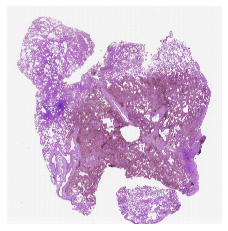

In [ ]:
path_LungFCP_01_0001_b1_image = r'/content/drive/MyDrive/WIKM/data/LungCancer/LungFCP-01-0001/images/LungFCP-01-0001_b1.tiff'

path_LungFCP_01_0001_b1_mask = r'/content/drive/MyDrive/WIKM/data/LungCancer/LungFCP-01-0001/annotations/LungFCP-01-0001_b1_annotation_00_R000G255B000.tiff'


image_LungFCP_01_0001_b1  = cv2.imread(path_LungFCP_01_0001_b1_image, 1) 

image_LungFCP_01_0001_b1_annotation_00_R000G255B000 = cv2.imread(path_LungFCP_01_0001_b1_mask, 1) 

plt.axis("off")
plt.imshow(image_LungFCP_01_0001_b1)



In [ ]:
from PIL import Image
Image.MAX_IMAGE_PIXELS = None

im = np.array(Image.open(path_LungFCP_01_0001_b1_image))
print(type(im))
print(im.dtype)
print(im.shape)

im_mask = np.array(Image.open(path_LungFCP_01_0001_b1_mask))
print(type(im_mask))
print(im_mask.dtype)
print(im_mask.shape)

<class 'numpy.ndarray'>
uint8
(9832, 9688, 3)
<class 'numpy.ndarray'>
uint8
(9832, 9688)


In [ ]:
!pip install patchify

Masking

In [ ]:
src2 = image_LungFCP_01_0001_b1_annotation_00_R000G255B000

src2 = cv2.resize(src2, image_LungFCP_01_0001_b1.shape[1::-1])

print(src2.shape)

print(src2.dtype)

masked = cv2.bitwise_and(image_LungFCP_01_0001_b1, src2)
# cv2_imshow(masked)

#make black region transparent
tmp = cv2.cvtColor(masked, cv2.COLOR_BGR2GRAY)
_, alpha = cv2.threshold(tmp, 0, 255, cv2.THRESH_BINARY)
b, g, r = cv2.split(masked)
rgba = [b, g, r, alpha]
masked_tr = cv2.merge(rgba, 4)

cv2_imshow(masked_tr)

In [ ]:
masked_tr.shape

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import glob

In [ ]:
print(len(os.listdir('/content/drive/MyDrive/WIKM/patchedImagesPNG512x512/Validation/both')))
print(len(os.listdir('/content/drive/MyDrive/WIKM/patchedImagesPNG512x512/Validation/in_situ')))
print(len(os.listdir('/content/drive/MyDrive/WIKM/patchedImagesPNG512x512/Validation/invasive')))
print(len(os.listdir('/content/drive/MyDrive/WIKM/patchedImagesPNG512x512/Validation/normal')))


print(len(os.listdir('/content/drive/MyDrive/WIKM/patchedImagesPNG512x512/Test/both')))
print(len(os.listdir('/content/drive/MyDrive/WIKM/patchedImagesPNG512x512/Test/in_situ')))
print(len(os.listdir('/content/drive/MyDrive/WIKM/patchedImagesPNG512x512/Test/invasive')))
print(len(os.listdir('/content/drive/MyDrive/WIKM/patchedImagesPNG512x512/Test/normal')))

print(len(os.listdir('/content/drive/MyDrive/WIKM/patchedImagesPNG512x512/Train/both')))
print(len(os.listdir('/content/drive/MyDrive/WIKM/patchedImagesPNG512x512/Train/in_situ')))
print(len(os.listdir('/content/drive/MyDrive/WIKM/patchedImagesPNG512x512/Train/invasive')))
print(len(os.listdir('/content/drive/MyDrive/WIKM/patchedImagesPNG512x512/Train/normal')))

10
54
158
821
10
69
241
789
12
141
1131
5579


Augmentation

In [ ]:
import cv2
import imutils # allows for image augmentation
from random import randint, uniform  # allows for random rotation degree, translation, gamma
from google.colab.patches import cv2_imshow
import numpy as np

import pathlib
import os


def save_image(img): # write to folder

  directory = "/content/drive/My Drive/WIKM/patchedAugmented"
  os.chdir(directory)
  
  random_int = randint(1, 100)

  patch_name = f'augment{random_int}.jpg'

  cv2.imwrite(patch_name, img)


def get_image():
  datasetPath = pathlib.Path("/content/drive/My Drive/WIKM/patchedImages100x100")
  patientDirs = sorted([str(pathlib.Path(datasetPath, patient)) for patient in os.listdir(datasetPath)]) # names of all the folders
  
  "patientDirs[0] --> /content/drive/My Drive/WIKM/patchedImages100x100/patient1"

  for patient_dir in patientDirs: # /content/drive/MyDrive/WIKM/patchedImages100x100/patient1/both/Patch1.tiff
    
    # INVASIVE IMAGES
    setPath = patient_dir + '/invasive' 

    patchDirs = sorted([str(pathlib.Path(setPath, patch)) for patch in os.listdir(setPath)]) # names of patches

    for patch in patchDirs[0:99]: # Only did the first 100 patches -- may change later at group discretion...
      augment(patch)

def gamma(img, gamma_value):
  inverse_gamma = 1 / gamma_value
 
  table = [((num / 255) ** inverse_gamma) * 255 for num in range(256)]
  table = np.array(table, np.uint8)
 
  return cv2.LUT(img, table)


def rotation(img):
  rotated = imutils.rotate(img, randint(0, 360))
  return rotated


def flip(img):
  flipped = cv2.flip(img, randint(-1, 1))
  return flipped


def augment(patch): # stopped execution at 10 minutes on local runtime
  patch_image = cv2.imread(patch)
  output_img = rotation(patch_image)
  output_img = flip(output_img)
  output_img = gamma(output_img, uniform(1.8, 2.2))
  
  cv2_imshow(output_img)
  
  save_image(output_img)

get_image()


Masking over all the slides and creating folders

In [ ]:
# Helper Functions

def maskOverImage(source, mask):
  source2 = cv2.resize(mask, source.shape[1::-1])

  dst = cv2.bitwise_and(source, source2)

  return dst

def createFolderandChdir(pathToFolder):
  if not os.path.exists(pathToFolder):
    os.makedirs(pathToFolder)

  os.chdir(pathToFolder)

In [ ]:
# Creating the JSON structure but with absolute paths
import pathlib
import os
import json
# os.chdir('/content/drive/My Drive/WIKM')
datasetPath = pathlib.Path("/content/drive/My Drive/WIKM/data/LungCancer")
pathDataset = []

patientDirs = sorted([str(pathlib.Path(datasetPath, patient)) for patient in os.listdir(datasetPath) if patient != "FinalPublishedResults"]) # names of all the folders

# print(patientDirs)
# print()

for patientNumber, patientDir in enumerate(patientDirs, 1):
  slidesImages = sorted(os.listdir(str(patientDir) + '/images'))
  maskImages = sorted(os.listdir(str(patientDir) + '/annotations'))

  slideDict = {}

  for slideNum, images in enumerate(slidesImages, 1):
    slideKey = f'slide{slideNum}'
    slideDict[slideKey] = {}
    slideDict[slideKey]['imgPath'] = str(pathlib.Path(str(patientDir), 'images', images).absolute())
    slideDict[slideKey]['invasive'] = list()
    slideDict[slideKey]['in_situ'] = list()
    slideDict[slideKey]['both'] = list()
    slideDict[slideKey]['airway'] = ""
    slideDict[slideKey]['blood'] = ""
    annotsForCurrSlide = [annot for annot in maskImages if annot[:18] == images[:-5]]

    for annotations in annotsForCurrSlide:
      pathToAnnotation = str(pathlib.Path(patientDir, 'annotations', annotations))
      serial = annotations[33:-5]

      if serial in ["R000G000B255","R001G000B255","R002G000B255"]: #in situ
          slideDict[slideKey]['in_situ'].append(pathToAnnotation)
      elif serial in ["R000G255B000", "R001G255B000", "R002G255B000", "R003G255B000", "R004G255B000", "R005G255B000", "R006G255B000"]: #invasive
          slideDict[slideKey]['invasive'].append(pathToAnnotation)
      elif serial == "R255G000B000": #both region
          slideDict[slideKey]['both'].append(pathToAnnotation)


    patientDirPathObj = pathlib.Path(patientDir)
    airPath = pathlib.Path(patientDirPathObj.parent, 'FinalPublishedResults', patientDirPathObj.name, 'histology', 'masks', 'airways')  #some don't have
    bloodPath = pathlib.Path(patientDirPathObj.parent, 'FinalPublishedResults', patientDirPathObj.name, 'histology', 'masks', 'blood')

    if os.path.exists(airPath):
        for air in os.listdir(airPath):
            if images[:-1].lower() == air.lower() or images[:-5].lower() == air[:-4].lower(): #some tif some png
                slideDict[slideKey]['airway'] = str(pathlib.Path(airPath, air).absolute()) # os.path.join(airPath, air)

    if os.path.exists(bloodPath):
        for bld in os.listdir(bloodPath):
            if images[:-1].lower() == bld.lower() or images[:-5].lower() == bld[:-4].lower():
                slideDict[slideKey]['blood'] = str(pathlib.Path(bloodPath, bld).absolute()) # os.path.join(bloodPath, bld)

  patientDict = {}
  patientDict['patient{}'.format(patientNumber)] = slideDict
  pathDataset.append(patientDict)

# print(pathDataset)
# print(json.dumps(pathDataset, indent = 5))

In [ ]:
import cv2
patient2Test = pathDataset[1]['patient2']['slide2']
# print(patient2Test)


masksList = []
for mask in patient2Test['invasive']:
  masksList.append(cv2.imread(mask))

for mask in patient2Test['in_situ']:
  masksList.append(cv2.imread(mask))


for num, testMask in enumerate(masksList):
  if num == 0:
    prevMask = None
    currentMask = testMask
  else:
    prevMask = currentMask
    currentMask = cv2.bitwise_or(testMask, prevMask)

mask_inv = cv2.bitwise_not(currentMask)
slide = cv2.imread(patient2Test['imgPath'])
#cv2_imshow(mask_inv)
print(currentMask.shape, mask_inv.shape, slide.shape)
dst = cv2.resize(mask_inv, slide.shape[1::-1])

rev_mask = cv2.bitwise_and(slide, dst)


cv2.imwrite('/content/drive/MyDrive/WIKM/testMask.png', rev_mask)
#cv2_imshow(rev_mask)

(12040, 25872, 3) (12040, 25872, 3) (12040, 25872, 3)


True

In [ ]:
wikmMaskedImagesFolder = '//content//drive//My Drive//WIKM//maskedImages'
os.chdir(wikmMaskedImagesFolder)
# took about 10 minutes 20 seconds
for patientDict in pathDataset:
  for patientNum in patientDict:
    os.chdir(wikmMaskedImagesFolder)
    patientFolder = wikmMaskedImagesFolder + '//' + patientNum
    createFolderandChdir(patientFolder)
    # print(patientFolder)

    for slideNum, slideDict in patientDict[patientNum].items():
      slideFolder = patientFolder + '//' + slideNum
      # print(slideFolder)
      createFolderandChdir(slideFolder)

      for slideKey, slideContents in slideDict.items():
        if slideKey == 'imgPath':
          slideImage = cv2.imread(slideContents)
        
        elif slideKey == 'invasive':
          invasiveFolder = slideFolder + '//invasive'
          createFolderandChdir(invasiveFolder)

          for imageNum, invasiveSlide in enumerate(slideContents, 1):
            imageName = str(patientNum) + '_{}'.format(slideNum) + '_INVASIVE_' + str(imageNum) + '.tiff'
            imageToMask = cv2.imread(invasiveSlide)
            maskedSlide = maskOverImage(slideImage, imageToMask)
            cv2.imwrite(imageName, maskedSlide)

        elif slideKey == 'in_situ':
          inSituFolder = slideFolder + '//in_situ'
          createFolderandChdir(inSituFolder)

          for imageNum, inSitu in enumerate(slideContents, 1):
            imageName = str(patientNum) + '_{}'.format(slideNum) + '_IN_SITU_' + str(imageNum) + '.tiff'
            imageToMask = cv2.imread(inSitu)
            maskedSlide = maskOverImage(slideImage, imageToMask)
            cv2.imwrite(imageName, maskedSlide)

        elif slideKey == 'both':
          both = slideFolder + '//both'
          createFolderandChdir(both)

          for imageNum, both in enumerate(slideContents, 1):
            imageName = str(patientNum) + '_{}'.format(slideNum) + '_BOTH_' + str(imageNum) + '.tiff'
            imageToMask = cv2.imread(both)
            maskedSlide = maskOverImage(slideImage, imageToMask)
            cv2.imwrite(imageName, maskedSlide)

        imageToMask = None


Patch from normal area

In [ ]:
!pip install patchify

In [ ]:
'''
Testing ...
'''
from patchify import patchify, unpatchify
from PIL import Image

wikmMaskedImagesFolder = '//content//drive//My Drive//WIKM//maskedImages'

wikmPatchedImagesFolder512x512 = '//content//drive//My Drive//WIKM//patchedImages512x512'

os.chdir(wikmMaskedImagesFolder)
wikmMaskedImagesPath = pathlib.Path(wikmMaskedImagesFolder)

# sum = 0
# patchNum = 1
for patientFolder in wikmMaskedImagesPath.iterdir():
  os.chdir(wikmMaskedImagesFolder)
  patientPath = pathlib.Path(wikmMaskedImagesFolder, patientFolder)

  for slideFolder in patientPath.iterdir():
    slidePath = pathlib.Path(patientPath, slideFolder)
    if slideFolder.name in ['both', 'in_situ', 'invasive']: # Checks for the right folder
      # print(slideFolder)

      for maskedImage in sorted(slidePath.iterdir()): # "Patching" the image
        thisImageTotalPatches = 1
        os.chdir(maskedImage.parent)
        print('--ACCESSING IMAGE--', maskedImage.absolute())
        image = cv2.imread(str(maskedImage.absolute()))

        patches = patchify(image, (512, 512, 3), step = 512)    # im is image // 100x100 patches // 3 is the for colored image // step
        # print('--ACCESSING IMAGE--', maskedImage.absolute())
        if not os.path.exists(wikmPatchedImagesFolder512x512 + '//' + patientFolder.name + '//' + slideFolder.name):
          os.makedirs(wikmPatchedImagesFolder512x512 + '//' + patientFolder.name + '//' + slideFolder.name)

        os.chdir(wikmPatchedImagesFolder512x512 + '//' + patientFolder.name + '//' + slideFolder.name)


        for i in range(patches.shape[0]): #0 is first dimension
            for j in range(patches.shape[1]): #1 is second dimension
              singlePatch = patches[i, j, 0, :, :, :]

              if not np.all(singlePatch == 0):
                cv2.imwrite(f'Patch{patchNum}.png', singlePatch)
                patchNum += 1
                  # thisImageTotalPatches += 1

        #   print('---FOLDER---:', maskedImage.absolute(), 'THIS IMAGE TOTAL PATCHES:', thisImageTotalPatches, '--- PROJECTED TOTAL AMOUNT OF PATCHES (SO FAR) --- :', patchNum)
        # sum += patchNum


# print(sum)

### delete patches that are almost all-black
(put them in a seperate 'black_folder' for now and once double checked, we'll remove them completely)

don't need to run this every time

In [ ]:
import cv2
import os
import numpy as np
import shutil

def delete_black(path): #input: folder path; output: # of images removed
    file_names = os.listdir(path)
    bad_set = set()
    for f in file_names:
        imgPath = os.path.join(path,f)
        if f in bad_set or os.path.isdir(imgPath):
            continue
        img = cv2.imread(imgPath, 1)
        rgb_mean = np.mean(img)
        if (rgb_mean > 230) or (rgb_mean < 10) or (rgb_mean == None):
            bad_set.add(f)
    if not os.path.exists(os.path.join(path,'black_folder')):
        os.makedirs(os.path.join(path,'black_folder'))
    bad_list = list(bad_set)
    bad_list.sort()
    for im in bad_list:
        old_fp = os.path.join(path, im)
        new_fp = os.path.join(path,'black_folder',im)
        shutil.copyfile(old_fp, new_fp)
        os.remove(old_fp)
    print("removing", len(bad_list), "images")
    return len(bad_list)


PATCHING (1/8/22)


In [ ]:
# --- load example patch
from PIL import Image
from pathlib import Path

original_wsi_dir = '/content/drive/MyDrive/WIKM/data/LungCancer'

os.chdir(original_wsi_dir)
original_wsi_path = pathlib.Path(original_wsi_dir)

for patientnum in original_wsi_path.iterdir():
  os.chdir(original_wsi_dir)
  patientnum_path = pathlib.Path(original_wsi_dir, patientnum)

  for slidefolder in patientnum_path.iterdir():
    slidepath = pathlib.Path(patientnum_path, slidefolder)
    if slidefolder in ['annotations', 'images']:
      print(slidefolder)

      for mask_and_wsi in sorted(slidepath.iterdir()):
        os.chdir(mask_and_wsi.parent)
        print('--Opening Image--', mask_and_wsi.absolute())
        dat = np.array(Image.open(mask_and_wsi.absolute()))


        # --- create mask (0 = label, 1 = background)
        lbl = np.array (image.open( #image ))
        lbl = (dat > 0).astype('uint8')
        #imshow(lbl[..., 0])

        # --- create patches of 256x256
        PATCH_SIZE = 256
        LBL_OF_INTEREST = 1

        y_min, x_min = 0, 0
        y_max, x_max = PATCH_SIZE, PATCH_SIZE

        # --- calculate number of iterations for y and x axis
        y_itrs = int(dat.shape[0] / PATCH_SIZE)
        x_itrs = int(dat.shape[1] / PATCH_SIZE)

        for y in range(y_itrs):
            
            for x in range(x_itrs):
                
                # --- crop (256, 256, 3) patch
                dat_patch = dat[y_min : y_max, x_min: x_max, :]
                lbl_patch = lbl[y_min : y_max, x_min: x_max, :]
                
                # --- check if patch is part of the group we want
                indexes, counts = np.unique(lbl_patch, return_counts=True)
                
                # --- example: want patches with more group 1
                if LBL_OF_INTEREST in indexes:
                    
                    # --- check if majority of cropped label is label of interest
                    if indexes[np.argmax(counts)] == LBL_OF_INTEREST:
                        
                        # --- save patch
                        #np.save('/content/drive/MyDrive/WIKM/Test_Images', patch)
                        pass
                    
                x_min += PATCH_SIZE
                x_max += PATCH_SIZE
            
            # --- reset x_min and x_max
            x_min = 0
            x_max = PATCH_SIZE
            
            y_min += PATCH_SIZE
            y_max += PATCH_SIZE

reverse patching (getting the normal region from the slides)

In [ ]:
pathDataset

In [ ]:
from patchify import patchify, unpatchify
from PIL import Image

wikmMaskedImagesFolder = '//content//drive//My Drive//WIKM//maskedImages'
wikmPatchedImagesFolderNorm = '//content//drive//My Drive//WIKM//normMaskedImages'

os.chdir(wikmMaskedImagesFolder)
wikmMaskedImagesPath = pathlib.Path(wikmMaskedImagesFolder)

def combineAllMasks(masksList):
  for maskNum, masksPath in enumerate(masksList):
    if maskNum == 0:
      currentMask = cv2.imread(masksPath)
      prevMask = None
    else:
      currentMask = cv2.bitwise_or(cv2.imread(masksPath), currentMask)
      prevMask = currentMask

  return currentMask


for patientDict in pathDataset: # remove [0] to do all patients
  print(patientDict)
  for patientKey, slideDict in patientDict.items(): # 1 value only
    print(patientKey, slideDict)
    for slideKey in slideDict:
      if not(patientKey == 'patient5' and slideKey == 'slide3'):
        if len(slideDict[slideKey]['both']) == 0:
          masksList = []

          for mask in slideDict[slideKey]['in_situ']:
            masksList.append(mask)

          for mask in slideDict[slideKey]['invasive']:
            masksList.append(mask)

          # reverse patch it through the both

        else:
          # reverse patch it through the in_situ and invasive combined
          masksList = slideDict[slideKey]['both']

        # combine the masks
        combinedMasks = combineAllMasks(masksList) 
        combinedMasksInv = cv2.bitwise_not(combinedMasks)
        slideImg = cv2.imread(slideDict[slideKey]['imgPath'])
                              
        assert combinedMasksInv.shape == slideImg.shape, ("not the same size!")

        normal = cv2.bitwise_and(slideImg, combinedMasksInv)

        os.chdir(wikmPatchedImagesFolderNorm)

        cv2.imwrite(f'{patientKey}_{slideKey}_normal.png', normal) # patient1_slide1_normal.png


{'patient1': {'slide1': {'imgPath': '/content/drive/My Drive/WIKM/data/LungCancer/LungFCP-01-0001/images/LungFCP-01-0001_b1.tiff', 'invasive': ['/content/drive/My Drive/WIKM/data/LungCancer/LungFCP-01-0001/annotations/LungFCP-01-0001_b1_annotation_00_R000G255B000.tiff'], 'in_situ': [], 'both': ['/content/drive/My Drive/WIKM/data/LungCancer/LungFCP-01-0001/annotations/LungFCP-01-0001_b1_annotation_00_R255G000B000.tiff'], 'airway': '', 'blood': ''}, 'slide2': {'imgPath': '/content/drive/My Drive/WIKM/data/LungCancer/LungFCP-01-0001/images/LungFCP-01-0001_b2.tiff', 'invasive': ['/content/drive/My Drive/WIKM/data/LungCancer/LungFCP-01-0001/annotations/LungFCP-01-0001_b2_annotation_00_R000G255B000.tiff'], 'in_situ': [], 'both': ['/content/drive/My Drive/WIKM/data/LungCancer/LungFCP-01-0001/annotations/LungFCP-01-0001_b2_annotation_00_R255G000B000.tiff'], 'airway': '', 'blood': ''}, 'slide3': {'imgPath': '/content/drive/My Drive/WIKM/data/LungCancer/LungFCP-01-0001/images/LungFCP-01-0001_b3.

In [ ]:
from patchify import patchify, unpatchify
from PIL import Image
import random

wikmPatchedImagesFolderNorm = '//content//drive//My Drive//WIKM//normMaskedImages'
wikmTrainNormalPatches = '/content/drive/MyDrive/WIKM/patchedImagesPNG256x256/Train/normal'
wikmTestNormalPatches = '//content//drive//My Drive//WIKM//normalPatches//Test'
wikmValidationNormalPatches = '//content//drive//My Drive//WIKM//normalPatches//Validation'
os.chdir(wikmPatchedImagesFolderNorm)

patchNum = 1
for imageName in os.listdir(wikmPatchedImagesFolderNorm):
  os.chdir(wikmPatchedImagesFolderNorm)
  print(imageName)
  image = cv2.imread(imageName)
  patches = patchify(image, (256, 256, 3), step = 256)    # im is image // 100x100 patches // 3 is the for colored image // step
  print('--ACCESSING IMAGE--', imageName)

  for i in range(patches.shape[0]): #0 is first dimension
      for j in range(patches.shape[1]): #1 is second dimension
        singlePatch = patches[i, j, 0, :, :, :]

        if not (np.all(singlePatch == 0) or np.all(singlePatch == 255)):
          #RNG = random.randint(1, 10)
          #if RNG == 1:
          #  os.chdir(wikmTestNormalPatches)
          #  cv2.imwrite(f'Patch{patchNum}.png', singlePatch) # test
          #elif RNG == 2:
          #  os.chdir(wikmValidationNormalPatches)
          #  cv2.imwrite(f'Patch{patchNum}.png', singlePatch) # validation
          #else:
          os.chdir(wikmTrainNormalPatches)
          cv2.imwrite(f'Patch{patchNum}.png', singlePatch) # train
        patchNum += 1

In [ ]:
normalPatchesFolder = '/content/drive/MyDrive/WIKM/patchedImagesPNG256x256/Train/normal'

normalPatches = os.listdir(normalPatchesFolder)
delete_black('/content/drive/MyDrive/WIKM/patchedImagesPNG256x256/Train/normal')
#for setType in normalPatches:
  # print(setType)
#  folderPath = os.path.join(normalPatchesFolder, setType)
#  print(folderPath)
  # for patch in os.listdir(os.path.join(normalPatchesFolder, setType)):
#  delete_black(folderPath)

removing 0 images


0

### loading//preprocessing different way

In [ ]:
import fnmatch

In [ ]:
imagePatches = glob('/content/drive/MyDrive/WIKM/patchedImagesPNG256x256/Train/*/*.png')


'''
class0 = norm
class1= invasive
class2 = in_situ
class3 = both
'''
pattern0 = '/content/drive/MyDrive/WIKM/patchedImagesPNG256x256/Train/normal/*.png'
pattern1 = '/content/drive/MyDrive/WIKM/patchedImagesPNG256x256/Train/invasive/*.png'
pattern2 = '/content/drive/MyDrive/WIKM/patchedImagesPNG256x256/Train/in_situ/*.png'
pattern3 = '/content/drive/MyDrive/WIKM/patchedImagesPNG256x256/Train/both/*.png'

class0 = fnmatch.filter(imagePatches, pattern0)
class1 = fnmatch.filter(imagePatches, pattern1)
class2 = fnmatch.filter(imagePatches, pattern2)
class3 = fnmatch.filter(imagePatches, pattern3)

In [ ]:
print(len(class0))
print(len(class1))
print(len(class2))
print(len(class3))

25287
4544
736
1040


In [ ]:
print(len(os.listdir('/content/drive/MyDrive/WIKM/patchedImagesPNG256x256/Train/normal')))
print(len(os.listdir('/content/drive/MyDrive/WIKM/patchedImagesPNG256x256/Train/both')))
print(len(os.listdir('/content/drive/MyDrive/WIKM/patchedImagesPNG256x256/Train/in_situ')))
print(len(os.listdir('/content/drive/MyDrive/WIKM/patchedImagesPNG256x256/Train/invasive')))

25287
1041
736
4544


In [ ]:
def process_images(lowerIndex,upperIndex):
    """
    Returns two arrays: 
        x is an array of resized images
        y is an array of labels
    """ 
    height = 256
    width = 256
    channels = 3
    x = [] #list to store image data
    y = [] #list to store corresponding class
    for img in imagePatches[lowerIndex:upperIndex]:
        full_image = cv2.imread(img)
        image = (cv2.resize(full_image, (width, height), interpolation = cv2.INTER_CUBIC))
        x.append(image)
        if img in class0:
            y.append(0)
        elif img in class1:
            y.append(1)
        elif img in class2:
          y.append(2)
        elif img in class3:
          y.append(3)
        else:
            return
    return x,y

In [ ]:
class_weights = generate_class_weights(y_train)
n_classes = len(class_weights)
print(n_classes)

In [ ]:
batch_size = 256
num_classes = 4
epochs = 80

model = Sequential()
model.add(Conv2D(16, kernel_size=3, activation='relu', padding='same', input_shape=(256, 256, 3)))
model.add(Conv2D(16, kernel_size=3, activation='relu', padding='same'))
model.add(Conv2D(16, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(32, kernel_size=3, activation='relu', padding='same'))
model.add(Conv2D(32, kernel_size=3, activation='relu', padding='same'))
model.add(Conv2D(32, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(64, kernel_size=3, activation='relu', padding='same'))
model.add(Conv2D(64, kernel_size=3, activation='relu', padding='same'))
model.add(Conv2D(64, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.35))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

In [ ]:
model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.Adam(lr=0.0001),
              metrics=['accuracy'])

In [ ]:
datagen = ImageDataGenerator(rescale = 1./255, 
                             shear_range = 0.2, 
                             zoom_range = 0.2, 
                             rotation_range=180, 
                             horizontal_flip=True, 
                             vertical_flip=True, 
                             fill_mode='wrap',
                             featurewise_center = True,
                             featurewise_std_normalization = True)

### VGG Classification 

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from glob import glob

#train_datagen = ImageDataGenerator(rotation_range=180, horizontal_flip=True, vertical_flip=True, fill_mode='wrap')
#train_generator = train_datagen.flow_from_directory(directory='patchedImages/patient1', class_mode='sparse', save_to_dir='preview', save_prefix='aug', save_format='jpeg')
#train_generator = train_datagen.flow_from_directory(directory='/content/drive/MyDrive/WIKM/patchedImages/patient1', class_mode='sparse', save_to_dir='preview', save_prefix='aug', save_format='jpeg')

# val_datagen = ImageDataGenerator()
# val_generator = val_datagen.flow_from_directory(...)
'''
output: tuple (images, labels)
images: (batch_size, image_size[0], image_size[1], num_channels)
labels: (batch_size,) int32
- 0-invasiive, 1-both (determined by class_name)
preview
'''

'\noutput: tuple (images, labels)\nimages: (batch_size, image_size[0], image_size[1], num_channels)\nlabels: (batch_size,) int32\n- 0-invasiive, 1-both (determined by class_name)\npreview\n'

In [ ]:
VGGIMAGE_SIZE = [224, 224]

datagen = ImageDataGenerator(rescale = 1./255, shear_range = 0.2, zoom_range = 0.2, rotation_range=180, horizontal_flip=True, vertical_flip=True, fill_mode='wrap',validation_split=0.2)

training_set = datagen.flow_from_directory(directory = 'patchedImagesPNG256x256/Train', target_size = (224, 224), shuffle = True,
                                            batch_size = 20,class_mode = 'sparse',subset='training')
val_set = datagen.flow_from_directory(directory = 'patchedImagesPNG256x256/Train', target_size = (224, 224), shuffle = True,
                                            batch_size = 20,class_mode = 'sparse',subset='validation')

Found 8101 images belonging to 3 classes.
Found 7081 images belonging to 3 classes.


In [ ]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
#from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.models import Sequential
from glob import glob
from keras.preprocessing.image import ImageDataGenerator
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import ImageFile
%matplotlib inline

In [ ]:
vgg = VGG16(input_shape = VGGIMAGE_SIZE + [3], weights='imagenet', include_top=False)

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
for layer in vgg.layers:
  layer.trainable = False

In [ ]:
folders = glob('/content/drive/MyDrive/WIKM/patchedImagesPNG256x256/Train/*')

x = Flatten()(vgg.output)

In [ ]:
x.shape

TensorShape([None, 25088])

In [ ]:
prediction = Dense(len(folders), activation='softmax')(x)

 
model = Model(inputs=vgg.input, outputs=prediction)

In [ ]:
#model.summary()
from tensorflow import losses, optimizers
#loss = losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = optimizers.Adam(learning_rate=1e-4)

model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = optimizer,
    metrics = ['accuracy'])

In [ ]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5



In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15034051253345942928
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14465892352
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7648758483114517847
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [ ]:
print(len(os.listdir('/content/drive/MyDrive/WIKM/patchedImagesPNG256x256/Train/normal')))
print(len(os.listdir('/content/drive/MyDrive/WIKM/patchedImagesPNG256x256/Train/both')))
print(len(os.listdir('/content/drive/MyDrive/WIKM/patchedImagesPNG256x256/Train/in_situ')))
print(len(os.listdir('/content/drive/MyDrive/WIKM/patchedImagesPNG256x256/Train/invasive')))

18670
1041
736
4544


In [ ]:
step_size_train = training_set.n//training_set.batch_size
step_size_valid = val_set.n//val_set.batch_size

with tf.device('/device:GPU:0'):
  vgg_model_train = model.fit_generator(
      generator = training_set,
      validation_data = val_set,
      epochs = 100,
      steps_per_epoch = step_size_train,
      validation_steps = step_size_valid,
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


Epoch 1/100
773/998 [======================>.......] - ETA: 31:00 - loss: 0.6235 - accuracy: 0.7515

UnknownError: ignored

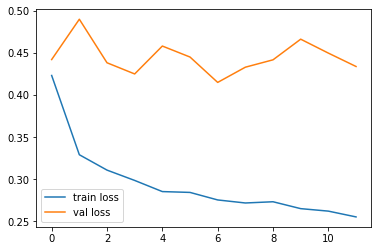

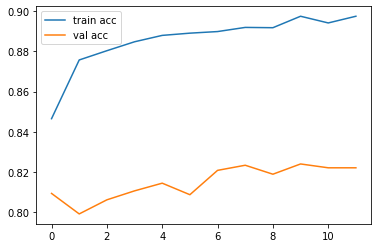

In [ ]:
# plot the loss
plt.plot(vgg_model_train.history['loss'], label='train loss')
plt.plot(vgg_model_train.history['val_loss'], label='val loss')
plt.legend()
plt.show()

# plot the accuracy
plt.plot(vgg_model_train.history['accuracy'], label='train acc')
plt.plot(vgg_model_train.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()


### Regular CNN Classification 512x512

In [ ]:
from tensorflow.python.keras.layers import Dense,Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout
from tensorflow.python.keras import Sequential
from keras.models import Model
from glob import glob
from keras.preprocessing.image import ImageDataGenerator
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import ImageFile
%matplotlib inline

In [ ]:
datagen = ImageDataGenerator(rescale = 1./255, shear_range = 0.2, zoom_range = 0.2, rotation_range=180, horizontal_flip=True, vertical_flip=True, fill_mode='wrap',validation_split=0.2)

training_set = datagen.flow_from_directory(directory = 'patchedImagesPNG256x256/Train', target_size = (256, 256), shuffle = True,
                                             seed=42,batch_size = 32,class_mode = 'sparse',subset='training')

val_set = datagen.flow_from_directory(directory = 'patchedImagesPNG256x256/Train', target_size = (256, 256), shuffle = True,
                                             seed=42,batch_size = 32,class_mode = 'sparse',subset='validation')

Found 25287 images belonging to 4 classes.
Found 6320 images belonging to 4 classes.


In [ ]:
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Input, Conv2D, MaxPooling2D, Dropout, Activation, GlobalAveragePooling2D
from keras import regularizers
from tensorflow.keras.optimizers import Adam


model = Sequential()
model.add(Conv2D(16, kernel_size=3, activation='relu', padding='same', input_shape=(256, 256, 3)))
model.add(Conv2D(16, kernel_size=3, activation='relu', padding='same'))
model.add(Conv2D(16, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(32, kernel_size=3, activation='relu', padding='same'))
model.add(Conv2D(32, kernel_size=3, activation='relu', padding='same'))
model.add(Conv2D(32, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(64, kernel_size=3, activation='relu', padding='same'))
model.add(Conv2D(64, kernel_size=3, activation='relu', padding='same'))
model.add(Conv2D(64, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.35))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 256, 256, 16)      448       
                                                                 
 conv2d_19 (Conv2D)          (None, 256, 256, 16)      2320      
                                                                 
 conv2d_20 (Conv2D)          (None, 256, 256, 16)      2320      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 128, 128, 16)     0         
 2D)                                                             
                                                                 
 conv2d_21 (Conv2D)          (None, 128, 128, 32)      4640      
                                                                 
 conv2d_22 (Conv2D)          (None, 128, 128, 32)      9248      
                                                      

In [ ]:
from keras.optimizers import adam_v2
optimizer = adam_v2.Adam(learning_rate=1e-4)
model.compile(loss='sparse_categorical_crossentropy',  optimizer=optimizer  , metrics=['accuracy'])

In [ ]:
step_size_train = training_set.n//training_set.batch_size
step_size_valid = val_set.n//val_set.batch_size

with tf.device('/device:GPU:0'):
  model_CNN_train = model.fit(
      training_set,
      validation_data = val_set,
      epochs = 100,
      steps_per_epoch = step_size_train,
      validation_steps = step_size_valid)

Epoch 1/100
790/790 [==============================] - 7061s 9s/step - loss: 0.4260 - accuracy: 0.8485 - val_loss: 0.6723 - val_accuracy: 0.7229
Epoch 2/100
790/790 [==============================] - 558s 706ms/step - loss: 0.3393 - accuracy: 0.8683 - val_loss: 0.7553 - val_accuracy: 0.7108
Epoch 3/100
790/790 [==============================] - 549s 694ms/step - loss: 0.3099 - accuracy: 0.8769 - val_loss: 0.7990 - val_accuracy: 0.6734
Epoch 4/100
  9/790 [..............................] - ETA: 7:07 - loss: 0.3242 - accuracy: 0.8646

KeyboardInterrupt: ignored

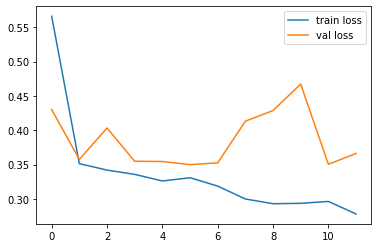

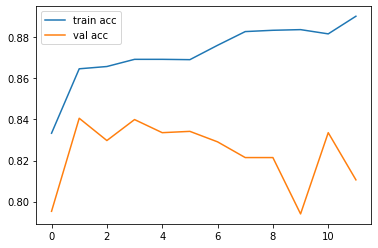

In [ ]:
# plot the loss
plt.plot(model_CNN_train.history['loss'], label='train loss')
plt.plot(model_CNN_train.history['val_loss'], label='val loss')
plt.legend()
plt.show()

# plot the accuracy
plt.plot(model_CNN_train.history['accuracy'], label='train acc')
plt.plot(model_CNN_train.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()


### Regular CNN 100x100 images

ResNet50

In [ ]:
from keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.python.keras.layers import Dense,Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout
from keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.models import Sequential
from glob import glob
from keras.preprocessing.image import ImageDataGenerator
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import ImageFile
%matplotlib inline

In [ ]:
#testing block - no need to run
i = 0
for batch in training_set:
#     print(batch)
     print(batch[0].shape) #float32(32, 256, 256, 3)
     print(batch[1].shape) #float32 (32,)
     i += 1
     if i > 2:
         break
# https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

(32, 224, 224, 3)
(32,)
(32, 224, 224, 3)
(32,)
(32, 224, 224, 3)
(32,)


### ResNet Classification

In [ ]:
import tensorflow as tf
print(tf.__version__) #need 2.7.0
from tensorflow.keras.applications import resnet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from keras.preprocessing.image import ImageDataGenerator

2.7.0


In [ ]:
#check GPU setting
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
class Config:
    # specify the shape of the inputs to our network (256 or 224 or 100)
    IMG_SHAPE = (224, 224, 3)

    # num of classes
    CLASSES = 3 #invasive, insitu, both for now

    BATCH_SIZE = 10 #32 
    EPOCHS = 50 #100
    INIT_LR = 0.001

    BASE_OUTPUT = "output" #folder

    MODEL_PATH = os.path.sep.join([BASE_OUTPUT, "resnet"])
    PLOT_PATH = os.path.sep.join([BASE_OUTPUT, "resnetPlot.png"])

# instantiate the config class
config = Config()

#### Loader for lung cancer dataset

In [ ]:
train_datagen = ImageDataGenerator(rotation_range=180, horizontal_flip=True, vertical_flip=True, fill_mode='wrap')
test_datagen = ImageDataGenerator() 
val_datagen = ImageDataGenerator() 

training_set = train_datagen.flow_from_directory(directory = 'patchedImagesPNG/Train', target_size = (224, 224), shuffle = True,
                                             seed=42,batch_size = 32,class_mode = 'sparse')

val_set = val_datagen.flow_from_directory(directory = 'patchedImagesPNG/Validation', target_size = (224, 224),shuffle=True,
                                             batch_size = 32,class_mode = 'sparse')

test_set= test_datagen.flow_from_directory(directory = 'patchedImagesPNG/Test',target_size = (224, 224),shuffle=False,
                                             class_mode='sparse',batch_size = 1)

#### Loader for new lung cancer dataset

In [ ]:
datagen = ImageDataGenerator(rotation_range=180, horizontal_flip=True, vertical_flip=True, fill_mode='wrap',validation_split=0.2)

training_set = datagen.flow_from_directory(directory = 'patchedImagesPNG256x256/Train', target_size = (224, 224), shuffle = True,
                                             seed=42,batch_size = 32,class_mode = 'sparse',subset='training')
val_set = datagen.flow_from_directory(directory = 'patchedImagesPNG256x256/Train', target_size = (224, 224), shuffle = True,
                                             seed=42,batch_size = 32,class_mode = 'sparse',subset='validation')

Found 28331 images belonging to 3 classes.
Found 7081 images belonging to 3 classes.


In [ ]:
with tf.device('/device:GPU:0'):
    resnet = resnet50.ResNet50(weights="imagenet", include_top=False,input_tensor=Input(config.IMG_SHAPE))
    for layer in resnet.layers:
        layer.trainable = False
    x = resnet.output
    x = AveragePooling2D((7,7))(x)
    x = Flatten()(x)
    x = Dense(521, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.2)(x)
    output = Dense(config.CLASSES, activation='softmax')(x)
    model = Model(resnet.input, output)

In [ ]:
with tf.device('/device:GPU:0'):
    resnet = resnet50.ResNet50(weights="imagenet", include_top=False,input_tensor=Input(config.IMG_SHAPE))
    for layer in resnet.layers:
        layer.trainable = False
    x = resnet.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    #x = AveragePooling2D((7,7))(x)
    #x = Flatten()(x)
    #x = Dense(521, activation='relu')(x)
    #x = Dropout(0.2)(x)
    #x = Dense(256, activation='relu')(x)
    #x = Dropout(0.2)(x)
    output = Dense(config.CLASSES, activation='softmax')(x)
    model = Model(resnet.input, output)

In [ ]:
from keras.applications import densenet

In [ ]:
### TRY NEXT


with tf.device('/device:GPU:0'):
    resnet = keras.applications.densenet.DenseNet201(weights="imagenet", include_top=False,input_tensor=Input(config.IMG_SHAPE))
    for layer in resnet.layers:
        layer.trainable = False
    x = resnet.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    #x = AveragePooling2D((7,7))(x)
    #x = Flatten()(x)
    #x = Dense(521, activation='relu')(x)
    #x = Dropout(0.2)(x)
    #x = Dense(256, activation='relu')(x)
    #x = Dropout(0.2)(x)
    output = Dense(config.CLASSES, activation='softmax')(x)
    model = Model(resnet.input, output)

In [ ]:
# resnet.summary()

In [ ]:
# model.summary()

#### Training Lung

In [ ]:
from keras.callbacks import ModelCheckpoint
checkpointer_benchmark = ModelCheckpoint(filepath='lung_histopathology_resnet50_best.hdf5', verbose=1, save_best_only=True)

In [ ]:
early_stopping_monitor = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')

In [ ]:
#tf.keras.optimizers.schedules.ExponentialDecay(...) do it later https://keras.io/api/optimizers/
criterion = tf.keras.optimizers.Adam(config.INIT_LR)
print("compiling model")
model.compile(loss="sparse_categorical_crossentropy", optimizer=criterion, metrics=["accuracy"])
print("training model")
history = model.fit(training_set, batch_size=config.BATCH_SIZE, epochs=config.EPOCHS, validation_data=val_set, verbose=1)

#### Training Bone

In [ ]:
#tf.keras.optimizers.schedules.ExponentialDecay(...) do it later https://keras.io/api/optimizers/
criterion = tf.keras.optimizers.Adam(config.INIT_LR)
print("compiling model")
model.compile(loss="sparse_categorical_crossentropy", optimizer=criterion, metrics=["accuracy"])
print("training model")
history = model.fit(training_set, validation_steps = 26, epochs=50, steps_per_epoch=26, validation_data=val_set, verbose=1)

compiling model
training model
Epoch 1/50
26/26 [==============================] - 561s 22s/step - loss: 0.6471 - accuracy: 0.7452 - val_loss: 0.6330 - val_accuracy: 0.7272
Epoch 2/50
26/26 [==============================] - 478s 19s/step - loss: 0.5289 - accuracy: 0.7885 - val_loss: 0.6082 - val_accuracy: 0.7428
Epoch 3/50
26/26 [==============================] - 435s 17s/step - loss: 0.5120 - accuracy: 0.8005 - val_loss: 0.6142 - val_accuracy: 0.7452
Epoch 4/50
26/26 [==============================] - 403s 16s/step - loss: 0.5597 - accuracy: 0.7981 - val_loss: 0.6042 - val_accuracy: 0.7464
Epoch 5/50
26/26 [==============================] - 370s 14s/step - loss: 0.4235 - accuracy: 0.8341 - val_loss: 0.5249 - val_accuracy: 0.7704
Epoch 6/50
26/26 [==============================] - 370s 14s/step - loss: 0.4225 - accuracy: 0.8474 - val_loss: 0.5755 - val_accuracy: 0.7752
Epoch 7/50
26/26 [==============================] - 346s 14s/step - loss: 0.4424 - accuracy: 0.8341 - val_loss: 0.602

In [ ]:
import matplotlib.pyplot as plt
def plot_loss(H, plotPath):
    '''
    input: H - training history variable
          plotPath - where to save output plot
    '''
    # construct a plot that plots and saves the training history
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(H.history["loss"], label="train_loss")
    plt.plot(H.history["val_loss"], label="val_loss")
    plt.title("Train & Validation Loss")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.legend(loc="lower left")
    plt.savefig(plotPath)
 
def plot_acc(H, plotPath):
    '''
    input: H - training history variable
                 plotPath - where to save output plot
    '''
    # construct a plot that plots and saves the training history
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(H.history["accuracy"], label="train_acc")
    plt.plot(H.history["val_accuracy"], label="val_acc")
    plt.title("Train & Validation Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Accuracy")
    plt.legend(loc="lower left")
    plt.savefig(plotPath)

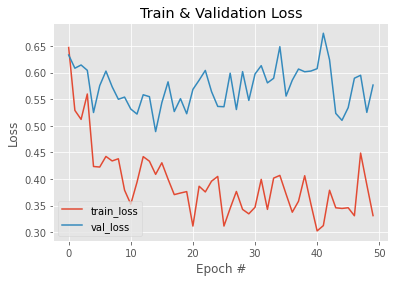

In [ ]:
plot_loss(history, config.PLOT_PATH)

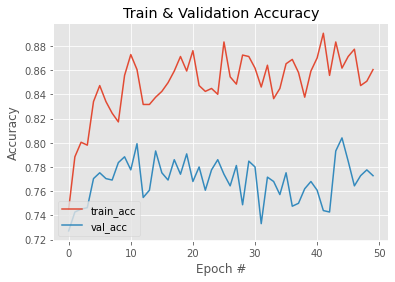

In [ ]:
plot_acc(history, config.PLOT_PATH)

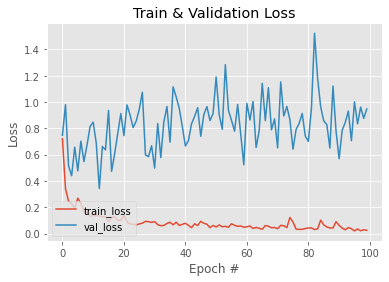

In [ ]:
plot_loss(history, 'output/resnetBoneLoss.png')

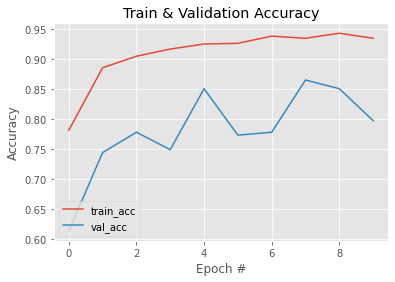

In [ ]:
plot_acc(history, 'output/resnetBoneAcc.png')

### BONE Classification

#### VGG16 BONE 100 epoch


In [ ]:
VGGIMAGE_SIZE = [224, 224]

datagen = ImageDataGenerator(rotation_range=180, horizontal_flip=True, vertical_flip=True, fill_mode='wrap',validation_split=0.2)

training_set = datagen.flow_from_directory(directory = 'OsteosarcomaData', target_size = (224, 224), shuffle = True,
                                             seed=42,batch_size = 32,class_mode = 'sparse',subset='training')
val_set = datagen.flow_from_directory(directory = 'OsteosarcomaData', target_size = (224, 224), shuffle = True,
                                             seed=42,batch_size = 32,class_mode = 'sparse',subset='validation')

Found 836 images belonging to 3 classes.
Found 207 images belonging to 3 classes.


In [ ]:
vgg = VGG16(input_shape = VGGIMAGE_SIZE + [3], weights='imagenet', include_top=False)

for layer in vgg.layers:
  layer.trainable = False

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
folders = glob('/content/drive/MyDrive/WIKM/OsteosarcomaData/*')

x = Flatten()(vgg.output)

In [ ]:
prediction = Dense(len(folders), activation='softmax')(x)

model = Model(inputs=vgg.input, outputs=prediction)

In [ ]:
#model.summary()
from tensorflow import losses, optimizers
#loss = losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = optimizers.Adam(learning_rate=1e-4)

model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = optimizer,
    metrics = ['accuracy'])

In [ ]:
step_size_train = training_set.n//training_set.batch_size
step_size_valid = val_set.n//val_set.batch_size

with tf.device('/device:GPU:0'):
  vgg_model_train = model.fit_generator(
      generator = training_set,
      validation_data = val_set,
      epochs = 100,
      steps_per_epoch = step_size_train,
      validation_steps = step_size_valid,
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


Epoch 1/100
26/26 [==============================] - 254s 9s/step - loss: 5.3702 - accuracy: 0.5634 - val_loss: 4.2323 - val_accuracy: 0.6146
Epoch 2/100
26/26 [==============================] - 33s 1s/step - loss: 2.5051 - accuracy: 0.7525 - val_loss: 3.2382 - val_accuracy: 0.6198
Epoch 3/100
26/26 [==============================] - 34s 1s/step - loss: 2.1419 - accuracy: 0.7848 - val_loss: 2.9725 - val_accuracy: 0.7031
Epoch 4/100
26/26 [==============================] - 34s 1s/step - loss: 1.4652 - accuracy: 0.8470 - val_loss: 2.6659 - val_accuracy: 0.7500
Epoch 5/100
26/26 [==============================] - 34s 1s/step - loss: 1.7067 - accuracy: 0.8371 - val_loss: 3.1128 - val_accuracy: 0.7031
Epoch 6/100
26/26 [==============================] - 33s 1s/step - loss: 1.5157 - accuracy: 0.8657 - val_loss: 2.3003 - val_accuracy: 0.7865
Epoch 7/100
26/26 [==============================] - 34s 1s/step - loss: 1.5055 - accuracy: 0.8483 - val_loss: 2.9056 - val_accuracy: 0.7708
Epoch 8/100


In [ ]:
!pip install pyyaml h5py  # Required to save models in HDF5 format

In [ ]:
model.save('vgg_bone_model_100epoch.h5')

In [ ]:
xs, ys = next(training_set)

cv2_imshow(xs[0])

In [ ]:
logits = model.predict(xs)

pred = np.argmax(logits, axis=1)

df = pd.DataFrame(index=np.arange(pred.size))

# --- Define columns
df['true'] = ys[:, 0]
df['pred'] = pred
df['corr'] = df['true'] == df['pred']

# --- Print accuracy
print(df['corr'].mean())

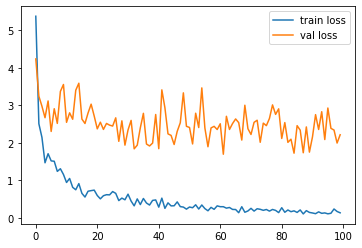

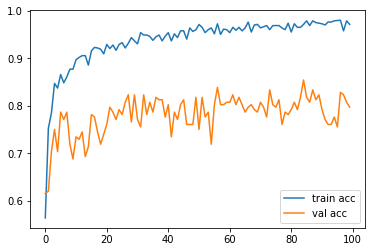

In [ ]:
# plot the loss
plt.plot(vgg_model_train.history['loss'], label='train loss')
plt.plot(vgg_model_train.history['val_loss'], label='val loss')
plt.legend()
plt.show()

# plot the accuracy
plt.plot(vgg_model_train.history['accuracy'], label='train acc')
plt.plot(vgg_model_train.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()


#### CNN BONE 100 epoch

In [ ]:
from tensorflow.python.keras.layers import Dense,Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout
from tensorflow.python.keras import Sequential
from keras.models import Model
from glob import glob
from keras.preprocessing.image import ImageDataGenerator
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import ImageFile
%matplotlib inline

In [ ]:
datagen = ImageDataGenerator(rotation_range=180, horizontal_flip=True, vertical_flip=True, fill_mode='wrap',validation_split=0.2)

training_set = datagen.flow_from_directory(directory = 'OsteosarcomaData', target_size = (256, 256), shuffle = True,
                                             seed=42,batch_size = 32,class_mode = 'sparse',subset='training')
val_set = datagen.flow_from_directory(directory = 'OsteosarcomaData', target_size = (256, 256), shuffle = True,
                                             seed=42,batch_size = 32,class_mode = 'sparse',subset='validation')

Found 836 images belonging to 3 classes.
Found 207 images belonging to 3 classes.


In [ ]:
class_weights={
    0: 1.0, # Non-Tumor
    1: 1.0, # Non-Viable Tumor
    2: 1.0, # Viable
    # make model more sensitive to positive class if necessary
}

In [ ]:
model = Sequential()

model.add(Conv2D(128, (3, 3), activation='relu', input_shape=(256,256,3), padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(3, activation = 'softmax'))

In [ ]:
#model.summary()
from tensorflow import losses, optimizers
#loss = losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)


model.compile(optimizer = 'adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])


In [ ]:
step_size_train = training_set.n//training_set.batch_size
step_size_valid = val_set.n//val_set.batch_size

with tf.device('/device:GPU:0'):
  model_CNN_train = model.fit(
      training_set,
      validation_data = val_set,
      epochs = 100,
      steps_per_epoch = step_size_train,
      validation_steps = step_size_valid)

Epoch 1/100
26/26 [==============================] - 214s 9s/step - loss: 848.3676 - accuracy: 0.3445 - val_loss: 1.0103 - val_accuracy: 0.4740
Epoch 2/100
26/26 [==============================] - 33s 1s/step - loss: 1.0511 - accuracy: 0.4639 - val_loss: 1.0150 - val_accuracy: 0.4948
Epoch 3/100
26/26 [==============================] - 29s 1s/step - loss: 1.0613 - accuracy: 0.5037 - val_loss: 1.0115 - val_accuracy: 0.4792
Epoch 4/100
26/26 [==============================] - 29s 1s/step - loss: 1.0055 - accuracy: 0.4963 - val_loss: 0.9195 - val_accuracy: 0.6302
Epoch 5/100
26/26 [==============================] - 29s 1s/step - loss: 0.9590 - accuracy: 0.5249 - val_loss: 0.8803 - val_accuracy: 0.5469
Epoch 6/100
26/26 [==============================] - 29s 1s/step - loss: 0.8654 - accuracy: 0.5808 - val_loss: 0.8430 - val_accuracy: 0.6250
Epoch 7/100
26/26 [==============================] - 29s 1s/step - loss: 0.8859 - accuracy: 0.5983 - val_loss: 0.6969 - val_accuracy: 0.6979
Epoch 8/10

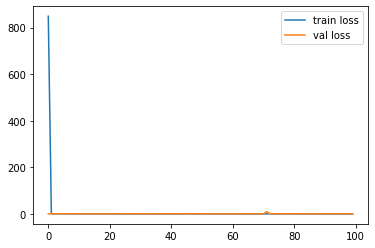

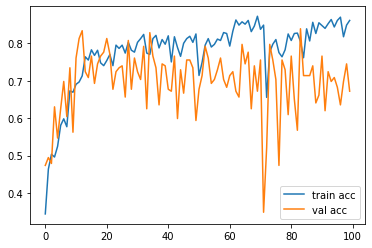

In [ ]:
# plot the loss
plt.plot(model_CNN_train.history['loss'], label='train loss')
plt.plot(model_CNN_train.history['val_loss'], label='val loss')
plt.legend()
plt.show()

# plot the accuracy
plt.plot(model_CNN_train.history['accuracy'], label='train acc')
plt.plot(model_CNN_train.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

### Segmentation Lung UNET

# New Section

In [ ]:
def multiclass_unet(n_classes = 3, IMG_HEIGHT = 256, IMG_WIDTH = 256, IMG_CHANNELS = 3):
  #Build the model
  inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
  s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

  #Encoder 
  c1 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
  c1 = tf.keras.layers.Dropout(0.1)(c1)
  c1 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
  p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

  c2 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
  c2 = tf.keras.layers.Dropout(0.1)(c2)
  c2 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
  p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
  
  c3 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
  c3 = tf.keras.layers.Dropout(0.2)(c3)
  c3 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
  p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
  
  c4 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
  c4 = tf.keras.layers.Dropout(0.2)(c4)
  c4 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
  p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
  
  c5 = tf.keras.layers.Conv2D(1024, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
  c5 = tf.keras.layers.Dropout(0.3)(c5)
  c5 = tf.keras.layers.Conv2D(1024, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

  #Decoder 
  u6 = tf.keras.layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
  u6 = tf.keras.layers.concatenate([u6, c4])
  c6 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
  c6 = tf.keras.layers.Dropout(0.2)(c6)
  c6 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
  
  u7 = tf.keras.layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
  u7 = tf.keras.layers.concatenate([u7, c3])
  c7 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
  c7 = tf.keras.layers.Dropout(0.2)(c7)
  c7 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
  
  u8 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
  u8 = tf.keras.layers.concatenate([u8, c2])
  c8 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
  c8 = tf.keras.layers.Dropout(0.1)(c8)
  c8 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
  
  u9 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
  u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
  c9 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
  c9 = tf.keras.layers.Dropout(0.1)(c9)
  c9 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
  
  outputs = tf.keras.layers.Conv2D(n_classes, (1, 1), activation='softmax')(c9)
  
  model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  return model

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda_1 (Lambda)              (None, 256, 256, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 256, 256, 64  1792        ['lambda_1[0][0]']               
                                )                                                                 
                                                                                            